# PCA Analysis

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
root_dir = '..\\datasets\\fma\\fma_small_932_features.csv'
df = pd.read_csv(root_dir)
df.head()

,autocorelation_00_kurtosis,autocorelation_00_max,autocorelation_00_mean,autocorelation_00_median,autocorelation_00_min,autocorelation_00_skew,autocorelation_00_std,autocorelation_00_sum,chroma_cens_00_kurtosis,chroma_cens_00_max,...,dtempo_changes,onset_count,low_energy_rate,harmonic_to_noise_rate,dynamic_range,swing_ratio,syncopation,roughness,warmth,Genre
0,141.768500,12364.4260,0.010876,-2.887901,-1593.9122,170.368180,3.016389,7.194268e+03,1.221379,0.379768,...,6,169,184.0,-14.303785,0.218490,1.109646,0.100849,191.356035,0.701712,Electronic
1,31.686200,2798.3555,0.002150,-0.398690,-1224.2454,88.129974,0.790848,1.422519e+03,-0.882889,0.659657,...,5,120,364.0,1.258749,0.147046,1.139929,0.312308,57.557036,0.605086,Electronic
2,11.787950,65289.0160,0.065771,-5.728954,-35123.4340,4982.006300,0.158547,4.347565e+04,-0.937324,0.564553,...,0,205,278.0,0.197590,0.661439,1.154552,0.112588,1374.684072,0.611777,Electronic
3,4.609666,60351.8500,1.028323,-2.132175,-29979.5370,5215.574700,0.071497,6.797144e+05,-0.495610,0.188383,...,11,211,191.0,0.258297,0.504590,1.079204,0.069990,2111.869221,0.401475,Electronic
4,113.699970,22080.5940,74.396010,34.283890,-5716.5230,437.943730,4.025559,4.917499e+07,-0.863015,0.472208,...,9,205,88.0,0.470797,0.281950,1.155421,0.107491,284.493888,0.461459,Electronic


## Data Preprocessing

In [31]:
df.groupby(["Genre"])['dtempo_00_kurtosis'].apply(lambda x:pd.isna(x).sum())

Genre
Electronic       220
Experimental      49
Folk              39
Hip-Hop          117
Instrumental      79
International     92
Pop              110
Rock              68
Name: dtempo_00_kurtosis, dtype: int64

In [32]:
def impute_by_genre(df, strategy='mean'):
    grouped = df.groupby('Genre')
    
    if strategy == 'mean':
        return grouped.apply(lambda group: group.fillna(group.mean())).reset_index()
    elif strategy == 'median':
        return grouped.apply(lambda group: group.fillna(group.median())).reset_index()
    else:
        raise ValueError("Unsupported strategy. Use 'mean' or 'median'.")

df = impute_by_genre(df)

In [33]:
df = df.drop("level_1", axis=1)
df.head()

,Genre,autocorelation_00_kurtosis,autocorelation_00_max,autocorelation_00_mean,autocorelation_00_median,autocorelation_00_min,autocorelation_00_skew,autocorelation_00_std,autocorelation_00_sum,chroma_cens_00_kurtosis,...,beat_count,dtempo_changes,onset_count,low_energy_rate,harmonic_to_noise_rate,dynamic_range,swing_ratio,syncopation,roughness,warmth
0,Electronic,141.768500,12364.4260,0.010876,-2.887901,-1593.9122,170.368180,3.016389,7.194268e+03,1.221379,...,64,6,169,184.0,-14.303785,0.218490,1.109646,0.100849,191.356035,0.701712
1,Electronic,31.686200,2798.3555,0.002150,-0.398690,-1224.2454,88.129974,0.790848,1.422519e+03,-0.882889,...,41,5,120,364.0,1.258749,0.147046,1.139929,0.312308,57.557036,0.605086
2,Electronic,11.787950,65289.0160,0.065771,-5.728954,-35123.4340,4982.006300,0.158547,4.347565e+04,-0.937324,...,66,0,205,278.0,0.197590,0.661439,1.154552,0.112588,1374.684072,0.611777
3,Electronic,4.609666,60351.8500,1.028323,-2.132175,-29979.5370,5215.574700,0.071497,6.797144e+05,-0.495610,...,94,11,211,191.0,0.258297,0.504590,1.079204,0.069990,2111.869221,0.401475
4,Electronic,113.699970,22080.5940,74.396010,34.283890,-5716.5230,437.943730,4.025559,4.917499e+07,-0.863015,...,72,9,205,88.0,0.470797,0.281950,1.155421,0.107491,284.493888,0.461459


## Scaling

In [35]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

X = df.drop("Genre", axis=1)

df['Genre'] = LabelEncoder().fit_transform(df['Genre'])
y = df["Genre"]

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## PCA

In [37]:
from sklearn.decomposition import PCA

pca = PCA(.95)

In [38]:
pca.fit(X_train)

PCA(n_components=0.95)

237


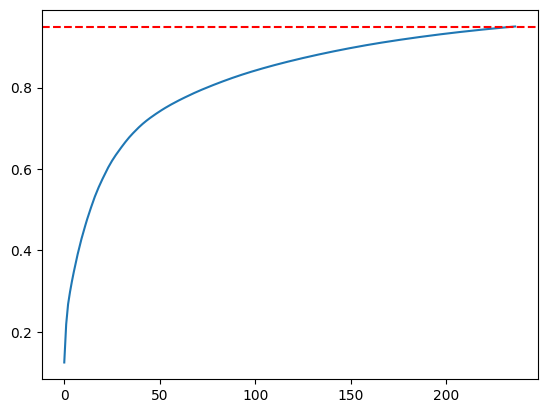

In [39]:
# pca.explained_variance_ratio_
# pca.singular_values_
print(len(pca.explained_variance_ratio_))
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

plt.plot(exp_var_cumul)
plt.axhline(y = 0.95, color = 'r', linestyle = '--') 
plt.show()

In [40]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

## Model Training

In [41]:
import tensorflow as tf

In [42]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=42)

print(X_train.shape, X_test.shape, X_valid.shape)
print(y_train.shape, y_test.shape, y_valid.shape)

(5595, 237) (1199, 237) (1199, 237)
(5595,) (1199,) (1199,)


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from tensorflow.keras import layers, models

tf.random.set_seed(42)
tf.keras.backend.clear_session()

n_classes = 8

y_train_encoded = to_categorical(y_train, n_classes)
y_valid_encoded = to_categorical(y_valid, n_classes)
y_test_encoded = to_categorical(y_test, n_classes)

In [46]:
model = tf.keras.Sequential()

model.add(layers.Input(shape=(237,)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.65))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.65))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.65))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.65))
model.add(layers.Dense(n_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
from pathlib import Path

logs = Path() / "my_logs" / "run_" / "Self"
checkpoint_filepath = "my_checkpoints.Self.model.keras"

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

history = model.fit(X_train, y_train_encoded, validation_data=(X_valid, y_valid_encoded), epochs=400, callbacks=callbacks)

Epoch 1/400
175/175 [==============================] - 2s 5ms/step - loss: 3.3957 - accuracy: 0.1314 - val_loss: 2.2043 - val_accuracy: 0.1301
Epoch 2/400
175/175 [==============================] - 1s 3ms/step - loss: 3.3168 - accuracy: 0.1244 - val_loss: 2.2019 - val_accuracy: 0.1359
Epoch 3/400
175/175 [==============================] - 1s 3ms/step - loss: 3.1439 - accuracy: 0.1403 - val_loss: 2.1799 - val_accuracy: 0.1393
Epoch 4/400
175/175 [==============================] - 1s 3ms/step - loss: 3.0664 - accuracy: 0.1353 - val_loss: 2.1531 - val_accuracy: 0.1426
Epoch 5/400
175/175 [==============================] - 1s 3ms/step - loss: 3.0065 - accuracy: 0.1348 - val_loss: 2.1282 - val_accuracy: 0.1485
Epoch 6/400
175/175 [==============================] - 1s 3ms/step - loss: 2.9154 - accuracy: 0.1394 - val_loss: 2.1054 - val_accuracy: 0.1535
Epoch 7/400
175/175 [==============================] - 1s 3ms/step - loss: 2.8098 - accuracy: 0.1466 - val_loss: 2.0859 - val_accuracy: 0.1626

In [49]:
model.evaluate(X_test, y_test_encoded)

38/38 [==============================] - 0s 905us/step - loss: 1.2558 - accuracy: 0.5680


[1.2557753324508667, 0.5679733157157898]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

# Top 3 accuracy